# Bayes by Backprop
An implementation of the algorithm described in https://arxiv.org/abs/1505.05424.  
This notebook accompanies the article at https://www.nitarshan.com/bayes-by-backprop.

In [3]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange




In [4]:
from tensorboardX import SummaryWriter
writer = SummaryWriter()
sns.set()
sns.set_style("dark")
sns.set_palette("muted")
sns.set_color_codes("muted")

In [7]:
#DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
print(torch.cuda.is_available())

False


## Data Preparation

In [209]:
BATCH_SIZE = 100
TEST_BATCH_SIZE = 5 #changed from 5

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        './fmnist', train=True, download=True,
        transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **LOADER_KWARGS)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        './fmnist', train=False, download=True,
        transform=transforms.ToTensor()),
    batch_size=TEST_BATCH_SIZE, shuffle=False, **LOADER_KWARGS)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = 5 #change from len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

CLASSES = 10
TRAIN_EPOCHS = 5 #changed from 20
SAMPLES = 2
TEST_SAMPLES = 100 #changed from 10

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

## Modelling
$$\underline{\text{Reparameterized Gaussian}}$$
$$\begin{aligned}
\theta &= (\mu, \rho)\\
\sigma &= \ln{(1+e^\rho)}\\
\mathcal{N}(x\vert \mu, \sigma) &= \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{(x-\mu)^2}{2\sigma^2}}\\
\ln{\mathcal{N}(x\vert \mu, \sigma)} &= -\ln{\sqrt{2\pi}} -\ln{\sigma} -\frac{(x-\mu)^2}{2\sigma^2}\\
P(\mathbf{w}) &= \prod_j{\mathcal{N}(\mathbf{w}_j \vert 0, \sigma^2)}\\
\ln{P(\mathbf{w})} &= \sum_j{\ln{\mathcal{N}(\mathbf{w}_j \vert 0, \sigma^2)}}\\
\end{aligned}$$

In [138]:
class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, input):
        return (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

$$\underline{\text{Scale Mixture Gaussian}}$$
$$\begin{align}
P(\mathbf{w}) &= \prod_j{\pi \mathcal{N}(\mathbf{w}_j \vert 0, \sigma_1^2) + (1-\pi) \mathcal{N}(\mathbf{w}_j \vert 0, \sigma_2^2)}\\
\ln{P(\mathbf{w})} &= \sum_j{\ln{(\pi \mathcal{N}(\mathbf{w}_j \vert 0, \sigma_1^2) + (1-\pi) \mathcal{N}(\mathbf{w}_j \vert 0, \sigma_2^2))}}\\
\end{align}$$

In [83]:
class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0,sigma1)
        self.gaussian2 = torch.distributions.Normal(0,sigma2)
    
    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi * prob1 + (1-self.pi) * prob2)).sum()

$$\pi = \frac{1}{2}$$
$$-\ln{\sigma_1} = 0$$
$$-\ln{\sigma_2} = 6$$

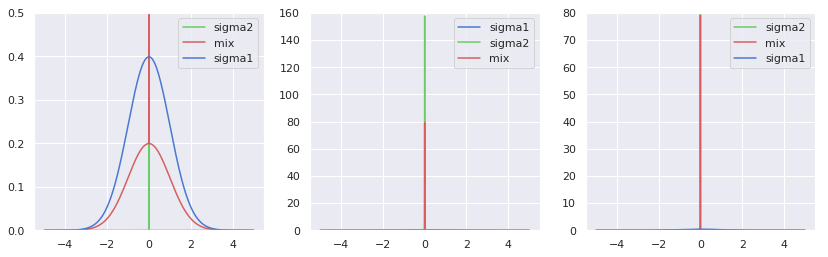

In [84]:
PI = 0.5
#SIGMA_1 = torch.cuda.FloatTensor([math.exp(-0)]) 
#SIGMA_2 = torch.cuda.FloatTensor([math.exp(-6)])
SIGMA_1 = torch.FloatTensor([math.exp(-0)]) 
SIGMA_2 = torch.FloatTensor([math.exp(-6)])

def visualize_scale_mixture_components():
    def show_lines():
        pass
    mix = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
    normal_1 = torch.distributions.Normal(0, SIGMA_1)
    normal_2 = torch.distributions.Normal(0, SIGMA_2)
    x_points = np.linspace(-5,5,10000)
    d1 = np.array([torch.exp(normal_1.log_prob(float(c))) for c in x_points])
    d2 = np.array([torch.exp(normal_2.log_prob(float(c))) for c in x_points])
    d3 = np.array([torch.exp(mix.log_prob(float(c))) for c in x_points])
    plt.subplots(1,3,figsize=(14,4))
    plt.subplot(1,3,1)
    plt.plot(x_points,d2,color="g")
    plt.plot(x_points,d3,color="r")
    plt.plot(x_points,d1,color="b")
    plt.legend(["sigma2", "mix", "sigma1"])
    plt.ylim(0,0.5)
    plt.subplot(1,3,2)
    plt.plot(x_points,d1,color="b")
    plt.plot(x_points,d2,color="g")
    plt.plot(x_points,d3,color="r")
    plt.legend(["sigma1", "sigma2", "mix"])
    plt.ylim(0,160)
    plt.subplot(1,3,3)
    plt.plot(x_points,d2,color="g")
    plt.plot(x_points,d3,color="r")
    plt.plot(x_points,d1,color="b")
    plt.legend(["sigma2", "mix", "sigma1"])
    plt.ylim(0,80)
    
visualize_scale_mixture_components()

In [191]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        # Prior distributions
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)

In [224]:
class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = BayesianLinear(28*28, 400)
        self.l2 = BayesianLinear(400, 400)
        self.l3 = BayesianLinear(400, 10)
    
    def forward(self, x, sample=False):
        x = x.view(-1, 28*28)
        x = F.relu(self.l1(x, sample))
        x = F.relu(self.l2(x, sample))
        x = F.log_softmax(self.l3(x, sample), dim=1)
        #x = self.l3(x, sample)
        return x
    
    def log_prior(self):
        return self.l1.log_prior \
               + self.l2.log_prior \
               + self.l3.log_prior
    
    def log_variational_posterior(self):
        return self.l1.log_variational_posterior \
               + self.l2.log_variational_posterior \
               + self.l2.log_variational_posterior
    
    def sample_elbo(self, input, target, samples=SAMPLES):
        outputs = torch.zeros(samples, BATCH_SIZE, CLASSES).to(DEVICE)
        log_priors = torch.zeros(samples).to(DEVICE)
        log_variational_posteriors = torch.zeros(samples).to(DEVICE)
        for i in range(samples):
            outputs[i] = self(input, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()
        negative_log_likelihood = F.nll_loss(outputs.mean(0), target, size_average=False)
        loss = (log_variational_posterior - log_prior)/NUM_BATCHES + negative_log_likelihood
        return loss, log_prior, log_variational_posterior, negative_log_likelihood

net = BayesianNetwork().to(DEVICE)

## Training

In [225]:
def write_weight_histograms(epoch):
    writer.add_histogram('histogram/w1_mu', net.l1.weight_mu,epoch)
    writer.add_histogram('histogram/w1_rho', net.l1.weight_rho,epoch)
    writer.add_histogram('histogram/w2_mu', net.l2.weight_mu,epoch)
    writer.add_histogram('histogram/w2_rho', net.l2.weight_rho,epoch)
    writer.add_histogram('histogram/w3_mu', net.l3.weight_mu,epoch)
    writer.add_histogram('histogram/w3_rho', net.l3.weight_rho,epoch)
    writer.add_histogram('histogram/b1_mu', net.l1.bias_mu,epoch)
    writer.add_histogram('histogram/b1_rho', net.l1.bias_rho,epoch)
    writer.add_histogram('histogram/b2_mu', net.l2.bias_mu,epoch)
    writer.add_histogram('histogram/b2_rho', net.l2.bias_rho,epoch)
    writer.add_histogram('histogram/b3_mu', net.l3.bias_mu,epoch)
    writer.add_histogram('histogram/b3_rho', net.l3.bias_rho,epoch)

def write_loss_scalars(epoch, batch_idx, loss, log_prior, log_variational_posterior, negative_log_likelihood):
    writer.add_scalar('logs/loss', loss, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/complexity_cost', log_variational_posterior-log_prior, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/log_prior', log_prior, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/log_variational_posterior', log_variational_posterior, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/negative_log_likelihood', negative_log_likelihood, epoch*NUM_BATCHES+batch_idx)

In [226]:
def train(net, optimizer, epoch):
    net.train()
    if epoch == 0: # write initial distributions
        write_weight_histograms(epoch)
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(DEVICE), target.to(DEVICE)
        net.zero_grad()
        loss, log_prior, log_variational_posterior, negative_log_likelihood = net.sample_elbo(data, target)
        loss.backward()
        optimizer.step()
        write_loss_scalars(epoch, batch_idx, loss, log_prior, log_variational_posterior, negative_log_likelihood)
    write_weight_histograms(epoch+1)

In [227]:
optimizer = optim.Adam(net.parameters())
for epoch in range(TRAIN_EPOCHS):
    print("epoch: ", epoch)
    train(net, optimizer, epoch)





  0%|          | 0/600 [00:00<?, ?it/s]

epoch:  0


/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  0%|          | 1/600 [00:00<02:46,  3.59it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  0%|          | 2/600 [00:00<02:31,  3.94it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  0%|          | 3/600 [00:00<02:22,  4.19it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(r





  5%|▌         | 30/600 [00:06<01:50,  5.17it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  5%|▌         | 31/600 [00:06<01:50,  5.17it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  5%|▌         | 32/600 [00:06<01:47,  5.29it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  6%|▌         | 33/600 [00:06<01:43,  5.46it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use re





 10%|█         | 60/600 [00:11<01:38,  5.50it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 10%|█         | 61/600 [00:11<01:38,  5.46it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 10%|█         | 62/600 [00:11<01:38,  5.47it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 10%|█         | 63/600 [00:12<01:38,  5.46it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use re





 15%|█▌        | 90/600 [00:17<01:40,  5.07it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 15%|█▌        | 91/600 [00:17<01:33,  5.42it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 15%|█▌        | 92/600 [00:17<01:28,  5.77it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 16%|█▌        | 93/600 [00:17<01:25,  5.91it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use re





 20%|██        | 120/600 [00:22<01:13,  6.55it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 20%|██        | 121/600 [00:22<01:11,  6.74it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 20%|██        | 122/600 [00:22<01:10,  6.82it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 20%|██        | 123/600 [00:22<01:08,  6.95it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 25%|██▌       | 150/600 [00:27<01:28,  5.07it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 25%|██▌       | 151/600 [00:27<01:36,  4.64it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 25%|██▌       | 152/600 [00:27<01:39,  4.51it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 26%|██▌       | 153/600 [00:28<01:43,  4.31it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 30%|███       | 180/600 [00:33<01:14,  5.63it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 30%|███       | 181/600 [00:33<01:18,  5.34it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 30%|███       | 182/600 [00:33<01:15,  5.53it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 30%|███       | 183/600 [00:33<01:13,  5.65it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us

 35%|███▌      | 210/600 [00:37<00:55,  7.06it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 35%|███▌      | 211/600 [00:37<00:54,  7.12it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 35%|███▌      | 212/600 [00:37<00:54,  7.12it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 36%|███▌      | 213/600 [00:38<00:54,  7.15it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use re





 40%|████      | 240/600 [00:42<00:53,  6.79it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 40%|████      | 241/600 [00:42<00:53,  6.73it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 40%|████      | 242/600 [00:42<00:54,  6.52it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 40%|████      | 243/600 [00:42<00:52,  6.75it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 45%|████▌     | 270/600 [00:46<00:46,  7.10it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 45%|████▌     | 271/600 [00:46<00:46,  7.07it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 45%|████▌     | 272/600 [00:46<00:46,  7.12it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 46%|████▌     | 273/600 [00:46<00:45,  7.11it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 50%|█████     | 300/600 [00:50<00:46,  6.39it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 50%|█████     | 301/600 [00:51<00:47,  6.34it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 50%|█████     | 302/600 [00:51<00:47,  6.32it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 50%|█████     | 303/600 [00:51<00:47,  6.28it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 55%|█████▌    | 330/600 [00:55<00:44,  6.07it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 55%|█████▌    | 331/600 [00:55<00:44,  5.99it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 55%|█████▌    | 332/600 [00:56<00:44,  6.07it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 56%|█████▌    | 333/600 [00:56<00:43,  6.11it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 60%|██████    | 360/600 [01:00<00:40,  6.00it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 60%|██████    | 361/600 [01:00<00:39,  6.12it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 60%|██████    | 362/600 [01:01<00:39,  6.10it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 60%|██████    | 363/600 [01:01<00:40,  5.91it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 65%|██████▌   | 390/600 [01:04<00:26,  7.78it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 65%|██████▌   | 391/600 [01:04<00:26,  7.76it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 65%|██████▌   | 392/600 [01:05<00:27,  7.66it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 66%|██████▌   | 393/600 [01:05<00:27,  7.61it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 70%|███████   | 420/600 [01:08<00:23,  7.78it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 70%|███████   | 421/600 [01:08<00:23,  7.78it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 70%|███████   | 422/600 [01:08<00:22,  7.78it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 70%|███████   | 423/600 [01:09<00:22,  7.80it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 75%|███████▌  | 450/600 [01:12<00:21,  6.94it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 75%|███████▌  | 451/600 [01:12<00:20,  7.20it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 75%|███████▌  | 452/600 [01:12<00:20,  7.33it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 76%|███████▌  | 453/600 [01:13<00:19,  7.47it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 80%|████████  | 480/600 [01:16<00:15,  7.73it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 80%|████████  | 481/600 [01:16<00:15,  7.75it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 80%|████████  | 482/600 [01:16<00:15,  7.77it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 80%|████████  | 483/600 [01:16<00:15,  7.73it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 85%|████████▌ | 510/600 [01:20<00:11,  7.62it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 85%|████████▌ | 511/600 [01:20<00:11,  7.64it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 85%|████████▌ | 512/600 [01:20<00:11,  7.45it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 86%|████████▌ | 513/600 [01:20<00:12,  7.15it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 90%|█████████ | 540/600 [01:24<00:07,  7.65it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 90%|█████████ | 541/600 [01:24<00:07,  7.67it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 90%|█████████ | 542/600 [01:24<00:07,  7.64it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 90%|█████████ | 543/600 [01:24<00:07,  7.66it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us

 95%|█████████▌| 570/600 [01:28<00:04,  7.34it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 95%|█████████▌| 571/600 [01:28<00:03,  7.46it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 95%|█████████▌| 572/600 [01:28<00:03,  7.53it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 96%|█████████▌| 573/600 [01:28<00:03,  7.61it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use re





100%|██████████| 600/600 [01:32<00:00,  7.73it/s]



  0%|          | 0/600 [00:00<?, ?it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  0%|          | 1/600 [00:00<01:17,  7.72it/s]

epoch:  1


/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  0%|          | 2/600 [00:00<01:17,  7.70it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  0%|          | 3/600 [00:00<01:17,  7.70it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  1%|          | 4/600 [00:00<01:17,  7.69it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(r





  5%|▌         | 31/600 [00:04<01:29,  6.39it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  5%|▌         | 32/600 [00:04<01:30,  6.28it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  6%|▌         | 33/600 [00:05<01:30,  6.28it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  6%|▌         | 34/600 [00:05<01:31,  6.16it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use re





 10%|█         | 61/600 [00:09<01:11,  7.52it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 10%|█         | 62/600 [00:09<01:10,  7.59it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 10%|█         | 63/600 [00:09<01:10,  7.65it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 11%|█         | 64/600 [00:09<01:10,  7.62it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use re





 15%|█▌        | 91/600 [00:13<01:06,  7.68it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 15%|█▌        | 92/600 [00:13<01:06,  7.69it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 16%|█▌        | 93/600 [00:13<01:05,  7.71it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 16%|█▌        | 94/600 [00:13<01:05,  7.69it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use re





 20%|██        | 121/600 [00:16<01:01,  7.76it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 20%|██        | 122/600 [00:17<01:01,  7.74it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 20%|██        | 123/600 [00:17<01:01,  7.74it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 21%|██        | 124/600 [00:17<01:01,  7.75it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 25%|██▌       | 151/600 [00:20<00:58,  7.68it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 25%|██▌       | 152/600 [00:20<00:58,  7.67it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 26%|██▌       | 153/600 [00:21<00:57,  7.73it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 26%|██▌       | 154/600 [00:21<00:57,  7.72it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 30%|███       | 181/600 [00:24<00:54,  7.68it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 30%|███       | 182/600 [00:24<00:54,  7.68it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 30%|███       | 183/600 [00:24<00:54,  7.70it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 31%|███       | 184/600 [00:25<00:54,  7.67it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 35%|███▌      | 211/600 [00:28<00:50,  7.70it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 35%|███▌      | 212/600 [00:28<00:50,  7.69it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 36%|███▌      | 213/600 [00:28<00:50,  7.70it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 36%|███▌      | 214/600 [00:28<00:50,  7.67it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 40%|████      | 241/600 [00:32<00:46,  7.74it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 40%|████      | 242/600 [00:32<00:46,  7.71it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 40%|████      | 243/600 [00:32<00:46,  7.69it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 41%|████      | 244/600 [00:32<00:46,  7.71it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 45%|████▌     | 271/600 [00:36<00:42,  7.69it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 45%|████▌     | 272/600 [00:36<00:42,  7.75it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 46%|████▌     | 273/600 [00:36<00:42,  7.76it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 46%|████▌     | 274/600 [00:36<00:42,  7.74it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 50%|█████     | 301/600 [00:40<00:39,  7.66it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 50%|█████     | 302/600 [00:40<00:38,  7.72it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 50%|█████     | 303/600 [00:40<00:38,  7.74it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 51%|█████     | 304/600 [00:40<00:38,  7.73it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 55%|█████▌    | 331/600 [00:44<00:34,  7.71it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 55%|█████▌    | 332/600 [00:44<00:34,  7.73it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 56%|█████▌    | 333/600 [00:44<00:34,  7.70it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 56%|█████▌    | 334/600 [00:44<00:34,  7.69it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 60%|██████    | 361/600 [00:48<00:31,  7.69it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 60%|██████    | 362/600 [00:48<00:30,  7.72it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 60%|██████    | 363/600 [00:48<00:30,  7.65it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 61%|██████    | 364/600 [00:48<00:30,  7.70it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 65%|██████▌   | 391/600 [00:51<00:26,  7.75it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 65%|██████▌   | 392/600 [00:52<00:26,  7.75it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 66%|██████▌   | 393/600 [00:52<00:26,  7.76it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 66%|██████▌   | 394/600 [00:52<00:26,  7.77it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 70%|███████   | 421/600 [00:55<00:23,  7.70it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 70%|███████   | 422/600 [00:55<00:23,  7.69it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 70%|███████   | 423/600 [00:56<00:22,  7.70it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 71%|███████   | 424/600 [00:56<00:22,  7.73it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us

 75%|███████▌  | 451/600 [00:59<00:19,  7.60it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 75%|███████▌  | 452/600 [00:59<00:19,  7.62it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 76%|███████▌  | 453/600 [01:00<00:19,  7.70it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 76%|███████▌  | 454/600 [01:00<00:18,  7.72it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use re





 80%|████████  | 481/600 [01:04<00:19,  6.17it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 80%|████████  | 482/600 [01:04<00:19,  6.09it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 80%|████████  | 483/600 [01:04<00:19,  6.08it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 81%|████████  | 484/600 [01:04<00:19,  6.10it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 85%|████████▌ | 511/600 [01:09<00:15,  5.91it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 85%|████████▌ | 512/600 [01:09<00:14,  5.93it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 86%|████████▌ | 513/600 [01:09<00:14,  5.99it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 86%|████████▌ | 514/600 [01:09<00:14,  6.05it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 90%|█████████ | 541/600 [01:14<00:08,  7.03it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 90%|█████████ | 542/600 [01:14<00:08,  6.99it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 90%|█████████ | 543/600 [01:14<00:07,  7.15it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 91%|█████████ | 544/600 [01:14<00:07,  7.19it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 95%|█████████▌| 571/600 [01:18<00:04,  6.70it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 95%|█████████▌| 572/600 [01:18<00:04,  6.27it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 96%|█████████▌| 573/600 [01:18<00:04,  6.63it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 96%|█████████▌| 574/600 [01:18<00:03,  6.89it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us

  0%|          | 1/600 [00:00<01:28,  6.76it/s]

epoch:  2


/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  0%|          | 2/600 [00:00<01:29,  6.65it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  0%|          | 3/600 [00:00<01:29,  6.65it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  1%|          | 4/600 [00:00<01:32,  6.43it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(r





  5%|▌         | 31/600 [00:04<01:28,  6.44it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  5%|▌         | 32/600 [00:04<01:29,  6.36it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  6%|▌         | 33/600 [00:05<01:29,  6.36it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  6%|▌         | 34/600 [00:05<01:28,  6.36it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use re





 10%|█         | 61/600 [00:09<01:27,  6.14it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 10%|█         | 62/600 [00:09<01:28,  6.07it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 10%|█         | 63/600 [00:09<01:36,  5.56it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 11%|█         | 64/600 [00:10<01:30,  5.89it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use re

 15%|█▌        | 91/600 [00:14<01:15,  6.77it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 15%|█▌        | 92/600 [00:14<01:13,  6.90it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 16%|█▌        | 93/600 [00:14<01:11,  7.09it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 16%|█▌        | 94/600 [00:14<01:10,  7.19it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduct





 20%|██        | 121/600 [00:18<01:18,  6.11it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 20%|██        | 122/600 [00:18<01:19,  6.01it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 20%|██        | 123/600 [00:18<01:17,  6.14it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 21%|██        | 124/600 [00:19<01:18,  6.05it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us

 25%|██▌       | 151/600 [00:23<01:03,  7.06it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 25%|██▌       | 152/600 [00:23<01:03,  7.06it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 26%|██▌       | 153/600 [00:23<01:02,  7.19it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 26%|██▌       | 154/600 [00:23<01:01,  7.22it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use re





 30%|███       | 181/600 [00:28<01:09,  6.05it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 30%|███       | 182/600 [00:28<01:10,  5.89it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 30%|███       | 183/600 [00:28<01:10,  5.92it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 31%|███       | 184/600 [00:28<01:11,  5.82it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 35%|███▌      | 211/600 [00:33<01:05,  5.94it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 35%|███▌      | 212/600 [00:33<01:04,  6.00it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 36%|███▌      | 213/600 [00:33<01:04,  6.02it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 36%|███▌      | 214/600 [00:33<01:03,  6.08it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 40%|████      | 241/600 [00:37<01:05,  5.48it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 40%|████      | 242/600 [00:38<01:08,  5.19it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 40%|████      | 243/600 [00:38<01:08,  5.20it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 41%|████      | 244/600 [00:38<01:11,  5.01it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 45%|████▌     | 271/600 [00:43<00:52,  6.27it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 45%|████▌     | 272/600 [00:43<00:50,  6.47it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 46%|████▌     | 273/600 [00:43<00:49,  6.58it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 46%|████▌     | 274/600 [00:43<00:48,  6.74it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 50%|█████     | 301/600 [00:48<00:50,  5.90it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 50%|█████     | 302/600 [00:48<00:49,  6.07it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 50%|█████     | 303/600 [00:48<00:49,  6.06it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 51%|█████     | 304/600 [00:49<00:48,  6.13it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 55%|█████▌    | 331/600 [00:53<00:46,  5.75it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 55%|█████▌    | 332/600 [00:53<00:45,  5.84it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 56%|█████▌    | 333/600 [00:53<00:47,  5.64it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 56%|█████▌    | 334/600 [00:53<00:46,  5.75it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us

 60%|██████    | 361/600 [00:58<00:32,  7.28it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 60%|██████    | 362/600 [00:58<00:32,  7.21it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 60%|██████    | 363/600 [00:58<00:32,  7.26it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 61%|██████    | 364/600 [00:58<00:34,  6.79it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use re





 65%|██████▌   | 391/600 [01:02<00:28,  7.29it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 65%|██████▌   | 392/600 [01:02<00:28,  7.31it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 66%|██████▌   | 393/600 [01:02<00:28,  7.30it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 66%|██████▌   | 394/600 [01:02<00:27,  7.41it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 70%|███████   | 421/600 [01:07<00:29,  6.13it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 70%|███████   | 422/600 [01:07<00:28,  6.26it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 70%|███████   | 423/600 [01:07<00:28,  6.22it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 71%|███████   | 424/600 [01:07<00:28,  6.16it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us

 75%|███████▌  | 451/600 [01:11<00:20,  7.33it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 75%|███████▌  | 452/600 [01:11<00:20,  7.32it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 76%|███████▌  | 453/600 [01:11<00:19,  7.40it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 76%|███████▌  | 454/600 [01:11<00:19,  7.41it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use re

 80%|████████  | 481/600 [01:16<00:17,  6.92it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 80%|████████  | 482/600 [01:16<00:20,  5.82it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 80%|████████  | 483/600 [01:16<00:24,  4.76it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 81%|████████  | 484/600 [01:16<00:22,  5.06it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use re





 85%|████████▌ | 511/600 [01:21<00:13,  6.62it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 85%|████████▌ | 512/600 [01:21<00:13,  6.76it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 86%|████████▌ | 513/600 [01:21<00:12,  6.88it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 86%|████████▌ | 514/600 [01:21<00:12,  6.92it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us

 90%|█████████ | 541/600 [01:25<00:08,  7.11it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 90%|█████████ | 542/600 [01:25<00:07,  7.26it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 90%|█████████ | 543/600 [01:25<00:07,  7.32it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 91%|█████████ | 544/600 [01:26<00:07,  7.30it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use re





 95%|█████████▌| 571/600 [01:30<00:04,  6.74it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 95%|█████████▌| 572/600 [01:30<00:04,  6.36it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 96%|█████████▌| 573/600 [01:30<00:04,  6.20it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 96%|█████████▌| 574/600 [01:30<00:04,  5.95it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





  0%|          | 1/600 [00:00<01:28,  6.80it/s]

epoch:  3


/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  0%|          | 2/600 [00:00<01:28,  6.73it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  0%|          | 3/600 [00:00<01:31,  6.56it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  1%|          | 4/600 [00:00<01:33,  6.39it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(r





  5%|▌         | 31/600 [00:04<01:39,  5.74it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  5%|▌         | 32/600 [00:05<01:35,  5.94it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  6%|▌         | 33/600 [00:05<01:36,  5.89it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  6%|▌         | 34/600 [00:05<01:31,  6.22it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use re





 10%|█         | 61/600 [00:09<01:20,  6.72it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 10%|█         | 62/600 [00:09<01:20,  6.68it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 10%|█         | 63/600 [00:09<01:18,  6.81it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 11%|█         | 64/600 [00:10<01:17,  6.94it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use re





 15%|█▌        | 91/600 [00:14<01:33,  5.45it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 15%|█▌        | 92/600 [00:14<01:31,  5.58it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 16%|█▌        | 93/600 [00:15<01:31,  5.57it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 16%|█▌        | 94/600 [00:15<01:27,  5.80it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use re





 20%|██        | 121/600 [00:19<01:23,  5.76it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 20%|██        | 122/600 [00:20<01:19,  6.03it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 20%|██        | 123/600 [00:20<01:16,  6.22it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 21%|██        | 124/600 [00:20<01:24,  5.65it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 25%|██▌       | 151/600 [00:25<01:10,  6.38it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 25%|██▌       | 152/600 [00:25<01:12,  6.18it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 26%|██▌       | 153/600 [00:25<01:17,  5.77it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 26%|██▌       | 154/600 [00:25<01:11,  6.20it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 30%|███       | 181/600 [00:30<01:11,  5.90it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 30%|███       | 182/600 [00:30<01:11,  5.81it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 30%|███       | 183/600 [00:30<01:12,  5.78it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 31%|███       | 184/600 [00:30<01:11,  5.86it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 35%|███▌      | 211/600 [00:35<01:08,  5.65it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 35%|███▌      | 212/600 [00:35<01:07,  5.71it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 36%|███▌      | 213/600 [00:35<01:05,  5.89it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 36%|███▌      | 214/600 [00:35<01:07,  5.69it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 40%|████      | 241/600 [00:40<00:53,  6.74it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 40%|████      | 242/600 [00:40<00:54,  6.55it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 40%|████      | 243/600 [00:40<00:55,  6.41it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 41%|████      | 244/600 [00:40<00:57,  6.21it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 45%|████▌     | 271/600 [00:45<00:54,  6.01it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 45%|████▌     | 272/600 [00:45<00:54,  5.96it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 46%|████▌     | 273/600 [00:45<00:55,  5.91it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 46%|████▌     | 274/600 [00:45<00:56,  5.81it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 50%|█████     | 301/600 [00:49<00:46,  6.41it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 50%|█████     | 302/600 [00:49<00:47,  6.32it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 50%|█████     | 303/600 [00:50<00:47,  6.30it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 51%|█████     | 304/600 [00:50<00:46,  6.41it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 55%|█████▌    | 331/600 [00:54<00:46,  5.78it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 55%|█████▌    | 332/600 [00:54<00:45,  5.83it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 56%|█████▌    | 333/600 [00:55<00:46,  5.69it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 56%|█████▌    | 334/600 [00:55<00:45,  5.87it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 60%|██████    | 361/600 [00:59<00:47,  5.07it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 60%|██████    | 362/600 [01:00<00:47,  4.96it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 60%|██████    | 363/600 [01:00<00:46,  5.14it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 61%|██████    | 364/600 [01:00<00:44,  5.28it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 65%|██████▌   | 391/600 [01:05<00:39,  5.31it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 65%|██████▌   | 392/600 [01:05<00:37,  5.55it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 66%|██████▌   | 393/600 [01:05<00:41,  4.98it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 66%|██████▌   | 394/600 [01:05<00:43,  4.75it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 70%|███████   | 421/600 [01:10<00:31,  5.71it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 70%|███████   | 422/600 [01:10<00:30,  5.77it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 70%|███████   | 423/600 [01:11<00:30,  5.83it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 71%|███████   | 424/600 [01:11<00:29,  5.98it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 75%|███████▌  | 451/600 [01:16<00:30,  4.87it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 75%|███████▌  | 452/600 [01:16<00:30,  4.91it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 76%|███████▌  | 453/600 [01:16<00:28,  5.18it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 76%|███████▌  | 454/600 [01:16<00:31,  4.64it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 80%|████████  | 481/600 [01:21<00:19,  6.12it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 80%|████████  | 482/600 [01:21<00:19,  6.09it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 80%|████████  | 483/600 [01:21<00:19,  6.15it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 81%|████████  | 484/600 [01:21<00:18,  6.20it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us

 85%|████████▌ | 511/600 [01:25<00:11,  7.44it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 85%|████████▌ | 512/600 [01:25<00:11,  7.39it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 86%|████████▌ | 513/600 [01:25<00:11,  7.41it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 86%|████████▌ | 514/600 [01:26<00:11,  7.42it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use re

 90%|█████████ | 541/600 [01:29<00:08,  7.37it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 90%|█████████ | 542/600 [01:29<00:07,  7.40it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 90%|█████████ | 543/600 [01:30<00:07,  7.41it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 91%|█████████ | 544/600 [01:30<00:07,  7.45it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use re

 95%|█████████▌| 571/600 [01:33<00:03,  7.35it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 95%|█████████▌| 572/600 [01:34<00:03,  7.44it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 96%|█████████▌| 573/600 [01:34<00:03,  7.35it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 96%|█████████▌| 574/600 [01:34<00:03,  7.39it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use re





  0%|          | 1/600 [00:00<01:26,  6.95it/s]

epoch:  4


/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  0%|          | 2/600 [00:00<01:26,  6.89it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  0%|          | 3/600 [00:00<01:26,  6.88it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  1%|          | 4/600 [00:00<01:26,  6.89it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(r





  5%|▌         | 31/600 [00:04<01:21,  6.96it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  5%|▌         | 32/600 [00:04<01:23,  6.76it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  6%|▌         | 33/600 [00:04<01:22,  6.88it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




  6%|▌         | 34/600 [00:04<01:21,  6.98it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use re

 10%|█         | 61/600 [00:08<01:15,  7.15it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 10%|█         | 62/600 [00:08<01:15,  7.17it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 10%|█         | 63/600 [00:08<01:15,  7.14it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 11%|█         | 64/600 [00:08<01:14,  7.21it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduct





 15%|█▌        | 91/600 [00:13<01:14,  6.81it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 15%|█▌        | 92/600 [00:13<01:16,  6.67it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 16%|█▌        | 93/600 [00:13<01:18,  6.43it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 16%|█▌        | 94/600 [00:13<01:20,  6.25it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use re





 20%|██        | 121/600 [00:18<01:23,  5.74it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 20%|██        | 122/600 [00:18<01:34,  5.03it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 20%|██        | 123/600 [00:18<01:26,  5.48it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 21%|██        | 124/600 [00:18<01:21,  5.86it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 25%|██▌       | 151/600 [00:24<01:28,  5.09it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 25%|██▌       | 152/600 [00:24<01:27,  5.13it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 26%|██▌       | 153/600 [00:24<01:26,  5.16it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 26%|██▌       | 154/600 [00:24<01:23,  5.33it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 30%|███       | 181/600 [00:29<01:12,  5.80it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 30%|███       | 182/600 [00:29<01:11,  5.82it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 30%|███       | 183/600 [00:29<01:16,  5.42it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 31%|███       | 184/600 [00:30<01:14,  5.55it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 35%|███▌      | 211/600 [00:34<00:59,  6.56it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 35%|███▌      | 212/600 [00:34<00:58,  6.61it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 36%|███▌      | 213/600 [00:35<00:58,  6.65it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 36%|███▌      | 214/600 [00:35<00:58,  6.61it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us

 40%|████      | 241/600 [00:39<01:02,  5.74it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 40%|████      | 242/600 [00:39<01:01,  5.85it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 40%|████      | 243/600 [00:39<00:57,  6.23it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 41%|████      | 244/600 [00:39<00:53,  6.65it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use re





 45%|████▌     | 271/600 [00:44<00:58,  5.62it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 45%|████▌     | 272/600 [00:44<00:59,  5.55it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 46%|████▌     | 273/600 [00:44<00:56,  5.81it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 46%|████▌     | 274/600 [00:44<00:56,  5.72it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 50%|█████     | 301/600 [00:48<00:42,  6.99it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 50%|█████     | 302/600 [00:48<00:44,  6.67it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 50%|█████     | 303/600 [00:49<00:44,  6.64it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 51%|█████     | 304/600 [00:49<00:45,  6.49it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 55%|█████▌    | 331/600 [00:53<00:37,  7.12it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 55%|█████▌    | 332/600 [00:53<00:39,  6.73it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 56%|█████▌    | 333/600 [00:53<00:40,  6.55it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 56%|█████▌    | 334/600 [00:53<00:40,  6.52it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us

 60%|██████    | 361/600 [00:57<00:32,  7.34it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 60%|██████    | 362/600 [00:58<00:32,  7.24it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 60%|██████    | 363/600 [00:58<00:32,  7.32it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 61%|██████    | 364/600 [00:58<00:31,  7.38it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use re





 65%|██████▌   | 391/600 [01:02<00:31,  6.54it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 65%|██████▌   | 392/600 [01:02<00:31,  6.67it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 66%|██████▌   | 393/600 [01:02<00:31,  6.50it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 66%|██████▌   | 394/600 [01:02<00:31,  6.53it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 70%|███████   | 421/600 [01:06<00:26,  6.65it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 70%|███████   | 422/600 [01:06<00:26,  6.59it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 70%|███████   | 423/600 [01:07<00:26,  6.64it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 71%|███████   | 424/600 [01:07<00:26,  6.61it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 75%|███████▌  | 451/600 [01:11<00:26,  5.66it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 75%|███████▌  | 452/600 [01:11<00:26,  5.61it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 76%|███████▌  | 453/600 [01:11<00:25,  5.70it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 76%|███████▌  | 454/600 [01:12<00:25,  5.75it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 80%|████████  | 481/600 [01:16<00:19,  6.06it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 80%|████████  | 482/600 [01:16<00:18,  6.22it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 80%|████████  | 483/600 [01:16<00:18,  6.33it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 81%|████████  | 484/600 [01:16<00:18,  6.19it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 85%|████████▌ | 511/600 [01:21<00:15,  5.75it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 85%|████████▌ | 512/600 [01:21<00:14,  5.94it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 86%|████████▌ | 513/600 [01:21<00:14,  6.07it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 86%|████████▌ | 514/600 [01:21<00:14,  6.12it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 90%|█████████ | 541/600 [01:26<00:09,  6.01it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 90%|█████████ | 542/600 [01:26<00:09,  6.00it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 90%|█████████ | 543/600 [01:26<00:09,  5.80it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 91%|█████████ | 544/600 [01:26<00:09,  5.84it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us





 95%|█████████▌| 571/600 [01:30<00:04,  6.64it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 95%|█████████▌| 572/600 [01:30<00:04,  6.66it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 96%|█████████▌| 573/600 [01:31<00:04,  6.58it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




 96%|█████████▌| 574/600 [01:31<00:03,  6.58it/s]/home/marius/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please us

## Evaluation

### Model Ensemble

In [181]:
n_digits = 1
def test_ensemble():
    net.eval()
    correct = 0
    corrects = np.zeros(TEST_SAMPLES+1, dtype=int)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = torch.zeros(TEST_SAMPLES+1, TEST_BATCH_SIZE, CLASSES).to(DEVICE)
            for i in range(TEST_SAMPLES):
                outputs[i] = net(data, sample=True)
            outputs[TEST_SAMPLES] = net(data, sample=False)
            print("outputs size: ", outputs.size())
            #test = outputs.view((outputs.size(0), -1))
            #test = test[:,:,0]
            #plt.hist(test, bins=50)
            #plt.show()
            output = outputs.mean(0)
            mus = output.view(TEST_BATCH_SIZE, -1)
            std_devs = outputs.std(0).view(TEST_BATCH_SIZE, -1)
            print("output: ", output)
            print("mu: ", mu)
            print("std_dev: ", std_dev)
            alphas = torch.zeros(TEST_BATCH_SIZE, 10)
            for i in range(TEST_BATCH_SIZE):
                alpha[i] = get_alpha_from_Normal(mus.detach()[i], torch.diag(std_devs.detach()[i]))
            print("alphas: ", alphas)
        
            preds = preds = outputs.max(2, keepdim=True)[1]
            pred = output.max(1, keepdim=True)[1] # index of max log-probability
            corrects += preds.eq(target.view_as(pred)).sum(dim=1).squeeze().cpu().numpy()
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    for index, num in enumerate(corrects):
        if index < TEST_SAMPLES:
            print('Component {} Accuracy: {}/{}'.format(index, num, TEST_SIZE))
        else:
            print('Posterior Mean Accuracy: {}/{}'.format(num, TEST_SIZE))
    print('Ensemble Accuracy: {}/{}'.format(correct, TEST_SIZE))

test_ensemble()

outputs size:  torch.Size([101, 5, 10])
output:  tensor([[ -5.3446,  -2.3647,  -4.6414,  -2.0496,  -2.9164,  -1.2647,  -5.2167,
          -9.6661,  -1.1411,  -3.7749],
        [ -8.1260, -11.4431, -10.2332,  -0.6104,  -1.9825,  -2.7492,  -6.1990,
         -11.4411,  -2.7680,  -4.9724],
        [-13.1752,  -2.9913,  -6.8743,  -2.8541,  -0.4438,  -1.9743,  -8.6536,
          -8.5465,  -4.3562,  -7.2674],
        [ -8.0776,  -5.5073,  -7.4497,  -3.2105,  -0.2099,  -3.5377,  -5.5310,
          -6.4190,  -2.7238,  -5.7832],
        [ -6.9571,  -6.0402,  -7.5778,  -0.5790,  -1.3366,  -4.6374,  -6.1240,
          -5.7527,  -2.5947,  -6.1133]])
mu:  tensor([-1.9281, -5.8226, -3.3868, -3.8490, -5.5552, -1.2668, -0.8337, -6.1484,
        -4.1181, -3.7527])
std_dev:  tensor([0.3052, 0.3691, 0.3621, 0.3894, 0.3788, 0.3050, 0.1995, 0.3563, 0.3672,
        0.3590])
alphas:  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.

KeyboardInterrupt: 

In [196]:
def get_mu_from_Dirichlet(alpha):
    K = len(alpha)
    mu = torch.zeros(K)
    for i in range(K):
        mu_i = torch.log(alpha[i]) - 1/K * torch.sum(torch.log(alpha))
        mu[i] = mu_i
        
    return(torch.Tensor(mu))

def get_Sigma_from_Dirichlet(alpha):
    K = len(alpha)
    sum_of_inv = 1/K * torch.sum(1/alpha)
    Sigma = torch.zeros((K,K))
    for k in range(K):
        for l in range(K):
            delta = 1 if k==l else 0
            Sigma[k][l] = delta * 1/alpha[k] - 1/K*(1/alpha[k] + 1/alpha[l] - sum_of_inv)
            
    return(torch.Tensor(Sigma))


def get_alpha_from_Normal(mu, Sigma):
    alpha = []
    K = len(Sigma[0])
    sum_exp = torch.sum(torch.exp(-1*torch.Tensor(mu)))
    for k in range(K):
        alpha.append(1/Sigma[k][k]*(1 - 2/K + torch.exp(mu[k])/K**2 * sum_exp))
        
    return(torch.Tensor(alpha))

alpha_test = torch.Tensor([1.3, 1.3])
print("alpha start: ", alpha_test)
mu_test = get_mu_from_Dirichlet(alpha_test)
print("mu: ", mu_test)
Sigma_test = get_Sigma_from_Dirichlet(alpha_test)
print("Sigma: ", Sigma_test)
alpha_end = get_alpha_from_Normal(mu_test, Sigma_test)
print("alpha end: ", alpha_end)

alpha start:  tensor([1.3000, 1.3000])
mu:  tensor([0., 0.])
Sigma:  tensor([[ 0.3846, -0.3846],
        [-0.3846,  0.3846]])
alpha end:  tensor([1.3000, 1.3000])


In [213]:
#play around a bit 
net.eval()
weight_mu = net.l3.weight.mu
weight_sigma = net.l3.weight.sigma
bias_mu = net.l3.bias.mu
bias_sigma = net.l3.bias.sigma
print("weights mu in last layer: ", weight_mu.size())
print("weights Sigma in last layer: ", weight_sigma.size())
print("bias mu in last layer: ", bias_mu.size())
print("bias Sigma in last layer: ", bias_sigma.size())

new_mu = torch.sum(weight_mu, dim=1) + bias_mu
new_sigma = torch.sum(weight_sigma, dim=1) + bias_sigma
print("mu: ", new_mu)
print("sigma: ", new_sigma)

new_mu = new_mu.detach().numpy()
new_sigma_diag = torch.diag(new_sigma).detach().numpy()
print("new sigma diag: ", new_sigma_diag)

#transform this to the realm of dirichlet
alpha = get_alpha_from_Normal(new_mu, new_sigma_diag)
print(alpha)

weights mu in last layer:  torch.Size([10, 400])
weights Sigma in last layer:  torch.Size([10, 400])
bias mu in last layer:  torch.Size([10])
bias Sigma in last layer:  torch.Size([10])
mu:  tensor([ 1.1386, -1.8352, -0.3438,  0.3895, -1.1046,  1.3248,  0.8076, -1.3083,
         0.9089, -2.3434], grad_fn=<AddBackward0>)
sigma:  tensor([1.1848, 1.3987, 1.2066, 1.2754, 1.2952, 1.4540, 1.3526, 1.4530, 1.3419,
        1.4008], grad_fn=<AddBackward0>)
new sigma diag:  [[1.1847584 0.        0.        0.        0.        0.        0.
  0.        0.        0.       ]
 [0.        1.3987265 0.        0.        0.        0.        0.
  0.        0.        0.       ]
 [0.        0.        1.2065642 0.        0.        0.        0.
  0.        0.        0.       ]
 [0.        0.        0.        1.2754259 0.        0.        0.
  0.        0.        0.       ]
 [0.        0.        0.        0.        1.2951509 0.        0.
  0.        0.        0.       ]
 [0.        0.        0.        0.        

TypeError: exp(): argument 'input' (position 1) must be Tensor, not numpy.float32

### Model Uncertainty

#### In-Domain Uncertainty

In [228]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

tensor([9, 2, 1, 1, 6])


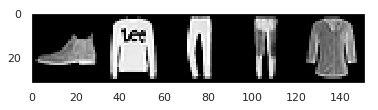

In [229]:
fmnist_sample = iter(test_loader).next()
fmnist_sample[0] = fmnist_sample[0].to(DEVICE)
print(fmnist_sample[1])
sns.set_style("dark")
show(make_grid(fmnist_sample[0].cpu()))

[[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
  9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
  9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
  6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
  6 6 6 6 6 6 6 6 6 6 6 

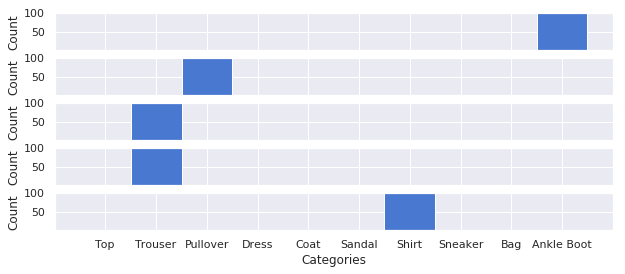

In [235]:
net.eval()
fmnist_outputs = net(fmnist_sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy()
for _ in range(99):
    fmnist_outputs = np.append(fmnist_outputs, net(fmnist_sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy(), axis=1)
sns.set_style("darkgrid")
print(fmnist_outputs)
plt.subplots(TEST_BATCH_SIZE,1,figsize=(10,4))
for i in range(TEST_BATCH_SIZE):
    plt.subplot(TEST_BATCH_SIZE,1,i+1)
    plt.ylim(0,100)
    plt.xlabel("Categories")
    plt.xticks(range(10), ["Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])
    plt.ylabel("Count")
    plt.yticks(range(50,101,50))
    plt.hist(fmnist_outputs[i], np.arange(-0.5, 10, 1))
             
plt.savefig("fmnist_samples.png")             

fmnist output size:  torch.Size([100, 5, 10])
alphas:  tensor([[4.2025e-01, 4.4624e-01, 6.5228e-01, 3.8360e-01, 7.9124e-01, 6.2506e+00,
         9.3138e-01, 7.4104e+01, 3.3658e-01, 4.5614e+07],
        [4.3123e+02, 2.6681e-01, 4.8480e+11, 1.2155e+00, 4.4987e+04, 2.9214e-01,
         1.0935e+04, 2.9542e-01, 1.1523e+00, 3.9234e-01],
        [2.4165e+02, 2.3985e+20, 3.0141e+00, 2.2213e+02, 1.4373e+00, 1.1298e-01,
         2.0399e+00, 2.8907e-01, 1.0697e+01, 1.1673e-01],
        [1.4821e+01, 1.8882e+21, 7.7993e+00, 2.0763e+02, 1.6499e+00, 1.2731e-01,
         2.5319e+00, 5.2348e-01, 8.0251e-01, 1.6457e-01],
        [3.4440e+02, 4.8987e-01, 7.4529e+01, 1.2466e+01, 2.6230e+01, 5.1041e-01,
         7.0473e+05, 5.4700e-01, 1.0732e+00, 7.3832e-01]])


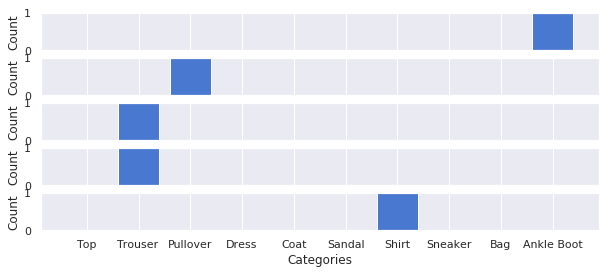

In [236]:
TEST_SIZE = 100
fmnist_outputs = torch.zeros(TEST_SIZE, TEST_BATCH_SIZE, 10) 
for i in range(TEST_SIZE):
    fmnist_outputs[i] = net(fmnist_sample[0], True).detach()

fmnist_output = torch.Tensor(fmnist_outputs)
print("fmnist output size: ", fmnist_output.size())
output = fmnist_outputs.mean(0)
mus = output.view(TEST_BATCH_SIZE, -1)
std_devs = fmnist_outputs.std(0).view(TEST_BATCH_SIZE, -1)
std_devs = torch.mul(std_devs, std_devs)
#print("output: ", output)
#print("mu: ", mu)
#print("std_dev: ", std_dev)
alphas = torch.zeros(TEST_BATCH_SIZE, 10)
for i in range(TEST_BATCH_SIZE):
    alphas[i] = get_alpha_from_Normal(mus.detach()[i], torch.diag(std_devs.detach()[i]))
print("alphas: ", alphas)

alphas_norm = (alphas/torch.sum(alphas)).numpy()

plt.subplots(TEST_BATCH_SIZE,1,figsize=(10,4))
for i in range(TEST_BATCH_SIZE):
    plt.subplot(TEST_BATCH_SIZE,1,i+1)
    plt.ylim(0,1)
    plt.xlabel("Categories")
    plt.xticks(range(10), ["Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])
    plt.ylabel("Count")
    alphas_norm = (alphas[i]/torch.sum(alphas[i])).numpy()
    plt.bar(range(0,10), alphas_norm)
    
plt.savefig("fmnist_alphas.png")

#### Out-of-Domain Uncertainty

In [218]:
mnist_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist', train=False, download=True, transform=transforms.ToTensor()), batch_size=TEST_BATCH_SIZE, shuffle=False)

tensor([7, 2, 1, 0, 4])


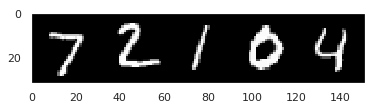

In [219]:
mnist_sample = iter(mnist_loader).next()
mnist_sample[0] = mnist_sample[0].to(DEVICE)
print(mnist_sample[1])
sns.set_style("dark")
show(make_grid(mnist_sample[0].cpu()))

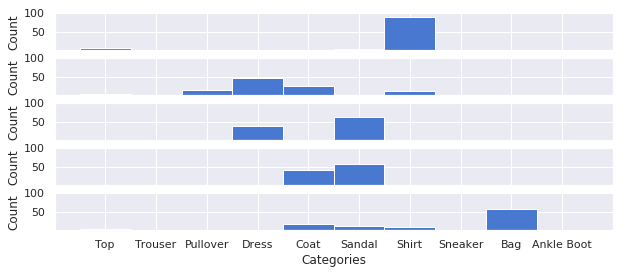

In [237]:
net.eval()
mnist_outputs = net(mnist_sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy()
for _ in range(99):
    mnist_outputs = np.append(mnist_outputs, net(mnist_sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy(), axis=1)

sns.set_style("darkgrid")
plt.subplots(TEST_BATCH_SIZE,1,figsize=(10,4))
for i in range(TEST_BATCH_SIZE):
    plt.subplot(TEST_BATCH_SIZE,1,i+1)
    plt.ylim(0,100)
    plt.xlabel("Categories")
    plt.xticks(range(10), ["Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])
    plt.ylabel("Count")
    plt.yticks(range(50,101,50))
    plt.hist(mnist_outputs[i], np.arange(-0.5, 10, 1))
    
plt.savefig("mnist_samples.png")

alphas:  tensor([[2.6438e+02, 4.5975e-01, 1.2222e+02, 3.8186e+00, 2.4365e+01, 2.0663e+01,
         3.5273e+03, 3.6409e-01, 4.7677e+00, 1.3791e+00],
        [1.4997e+00, 7.6176e-01, 4.6956e+00, 4.7207e+00, 3.2265e+00, 7.6847e-01,
         3.7041e+00, 7.0995e-01, 9.6826e-01, 9.3629e-01],
        [1.3598e+00, 1.3468e+00, 1.1318e+00, 6.4791e+00, 1.0991e+00, 1.5688e+01,
         1.3389e+00, 1.1346e+00, 1.0378e+00, 1.5152e+00],
        [6.6403e-01, 2.5154e-01, 1.3665e+00, 3.3576e+00, 5.5300e+01, 1.6040e+02,
         1.4228e+00, 9.7256e-01, 1.4046e+00, 3.4526e-01],
        [8.8547e+00, 1.0964e+00, 1.2733e+01, 1.2967e+00, 3.2800e+01, 8.3721e+00,
         2.4576e+01, 9.9646e-01, 1.0269e+02, 5.9032e-01]])


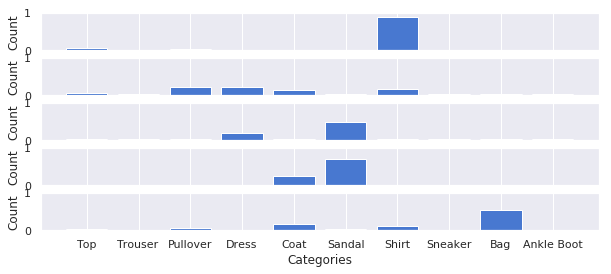

In [238]:
TEST_SIZE = 100
mnist_outputs = torch.zeros(TEST_SIZE, TEST_BATCH_SIZE, 10) 
for i in range(TEST_SIZE):
    mnist_outputs[i] = net(mnist_sample[0], True).detach()

mnist_output = torch.Tensor(mnist_outputs)
#print("fmnist output size: ", mnist_output.size())
output = mnist_outputs.mean(0)
mus = output.view(TEST_BATCH_SIZE, -1)
std_devs = mnist_outputs.std(0).view(TEST_BATCH_SIZE, -1)
std_devs = torch.mul(std_devs, std_devs)
#print("output: ", output)
#print("mu: ", mu)
#print("std_dev: ", std_dev)
alphas = torch.zeros(TEST_BATCH_SIZE, 10)
for i in range(TEST_BATCH_SIZE):
    alphas[i] = get_alpha_from_Normal(mus.detach()[i], torch.diag(std_devs.detach()[i]))
print("alphas: ", alphas)

alphas_norm = (alphas/torch.sum(alphas)).numpy()

plt.subplots(TEST_BATCH_SIZE,1,figsize=(10,4))
for i in range(TEST_BATCH_SIZE):
    plt.subplot(TEST_BATCH_SIZE,1,i+1)
    plt.ylim(0,1)
    plt.xlabel("Categories")
    plt.xticks(range(10), ["Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])
    plt.ylabel("Count")
    alphas_norm = (alphas[i]/torch.sum(alphas[i])).numpy()
    plt.bar(range(0,10), alphas_norm)
    
plt.savefig("mnist_alphas.png")

In [206]:
%load_ext watermark
%watermark --updated --datename --python --machine --watermark -p torch,numpy,matplotlib,tensorboardX,torchvision,seaborn

ModuleNotFoundError: No module named 'watermark'